### Transfer Learning

Some references:

- Transfer Learning with TF 2.0 (https://towardsdatascience.com/transfer-learning-with-tf-2-0-ff960901046d)
- How to Classify Photos of Dogs and Cats (with 97% accuracy) (https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)
- Models pre-trained on ImageNet (https://keras.io/applications/)

Dataset: Dogs vs. Cats dataset - https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

Neste notebook testam-se diferentes formas de utilização de redes disponibilizadas pelo módulo keras. Em concreto é testada a rede InceptionV3. Os testes realizados pretendem descobrir a eficácia desta rede neuronal quando o volume de dados para treino de uma rede neuronal é escasso. Os diferentes métodos analisados foram:
* A) Treino da rede sem pesos inicializados, ou seja, a rede é treinada partindo apenas da estrutura da rede e o nosso dataset
* B) Treino da rede com pesos inicializados pelo treino ImageNet, esta rede é depois treinada com o nosso dataset 
* C) Treino da rede com pesos inicializados pelo treino ImageNet, mas com a a base da rede congelada (camadas convolucionais que irão conter os pesos resultantes do treino ImageNet), sendo treinadas apenas as camadas adicionadas à rede 

De seguida, apresentam-se resultados obtidos com alguns dos parâmetros testados, onde teste se refere aos métodos apresentados em cima:

![resultados_p1](p1.png)
![resultados_p1](p2.png)
![resultados_p1](p3.png)

Analisando os resultados obtidos observamos que, os melhores resultados obtidos para a classificação de cães e gatos anda à volta 92%, estes valores conseguem ser obtidos com o método A apenas quando o tamanho do dataset utilizado para o treino é grande (23000 imagens). Um dataset de tamanho menor prejudica muito este método pois a rede não foi inicializada com nenhum valor de pré-treino, tendo de aprender apenas com o dataset que tivermos disponível. Quando são utilizadas apenas 2500 imagens para o treino, o método A deixa de ser eficaz e apenas os métodos B e C foram capazes de chegar a valores acima de 90% com este dataset. Com um dataset de apenas 250 imagens, o método C continua a obter valores semelhantes aos obtidos com datasets maiores, visto que a rede já está treinada para a deteção de imagens.

In [2]:
NCLASSES = 2
HEIGHT = 128
WIDTH = 128
NUM_CHANNELS = 3
BATCH_SIZE = 32

DATA_SET_COUNT = 23000
TEST_SET_COUNT = 2000
TRAIN_SET_COUNT = (DATA_SET_COUNT) * 0.8
VAL_SET_COUNT = (DATA_SET_COUNT) * 0.2
print(TRAIN_SET_COUNT, VAL_SET_COUNT)

# Especificar ponto a, b ou c
ponto = "b"

18400.0 4600.0


Load a model from keras database (https://keras.io/applications/) with weights trained on ImageNet

Para o método A, os pesos de ImageNet não serão carregados. Para os restantes métodos, estes pesos são utilizados.

In [3]:
if ponto == "a":
    base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights=None, input_tensor=None, input_shape=None, pooling=None)
else:
    base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None)

print(base_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Para o método C, o modelo base não será treinado. Para os restantes métodos, a base será treinada.

In [4]:
if ponto == "c":
    base_model.trainable = False
else:
    base_model.trainable = True

Add new layers to the top of the network

Global Average Pooling (GAP) performs an average for each of the feature maps. Assuming the last conv layer is 3x3x256, we have 256 feature maps. Global average pooling is a layer with 256 values, each being the average of a feature map.

Original paper for Global Average Pooling: Network In Network, Min Lin1, Qiang Chen, Shuicheng Yan (https://arxiv.org/pdf/1312.4400.pdf). Note the GAP is not the main theme of the paper.

In [5]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)

model_3 = models.Model(inputs=base_model.input, outputs=x)
print(model_3.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

conv2d_70 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, None, None, 1 258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, None, None, 1 576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, None, None, 1 576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_70 (Activation)      (None, None, None, 1 0           batch_normalization_70[0][0]     
__________________________________________________________________________________________________
activation

Auxiliary function for loading the dataset

In [6]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Load the dataset, replace the path with your own location of the dataset

In [7]:
data_dir = pathlib.Path('train/')
  
classNames = np.array(os.listdir(data_dir))
print(classNames)

AUTOTUNE = tf.data.experimental.AUTOTUNE
'''
listset = tf.data.Dataset.list_files("train/*/*.jpg")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
'''
listset = tf.data.Dataset.list_files("train/cats/*.jpg")
catset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


listset = tf.data.Dataset.list_files("train/dogs/*.jpg")
dogset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



['cats' 'dogs']


Split the dataset into training and validation sets

In [8]:
catset = catset.prefetch(buffer_size=AUTOTUNE)

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)

class_train_size = int(train_size / 2)
class_val_size = int(val_size / 2)

train_catset = catset.take(class_train_size)
train_catset = train_catset.shuffle(buffer_size = class_train_size)
#train_catset = train_catset.batch(batch_size=BATCH_SIZE)
#train_catset = train_catset.repeat();
val_catset = train_catset.skip(class_val_size)
#val_catset = val_dataset.batch(batch_size=BATCH_SIZE)
#val_catset = val_dataset.repeat()


dogset = dogset.prefetch(buffer_size=AUTOTUNE)

train_dogset = dogset.take(class_train_size)
train_dogset = train_dogset.shuffle(buffer_size = class_train_size)
#train_dogset = train_dogset.batch(batch_size=BATCH_SIZE)
#train_dogset = train_dogset.repeat();
val_dogset = train_dogset.skip(class_val_size)
#val_dogset = val_dogset.batch(batch_size=BATCH_SIZE)
#val_dogset = val_dogset.repeat()


train_dataset = train_catset.concatenate(train_dogset)
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.repeat()

val_dataset = val_catset.concatenate(val_dogset)
val_dataset = val_dataset.shuffle(buffer_size = train_size)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.repeat()

#train_dataset = dataset.take(train_size)
#train_dataset = train_dataset.shuffle(buffer_size = train_size)
#train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
#train_dataset = train_dataset.repeat();
#val_dataset = dataset.skip(train_size)
#val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
#val_dataset = val_dataset.repeat();


Load the test set

In [9]:
testset = tf.data.Dataset.list_files("test/*/*.jpg")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)



Show a batch of images from the dataset

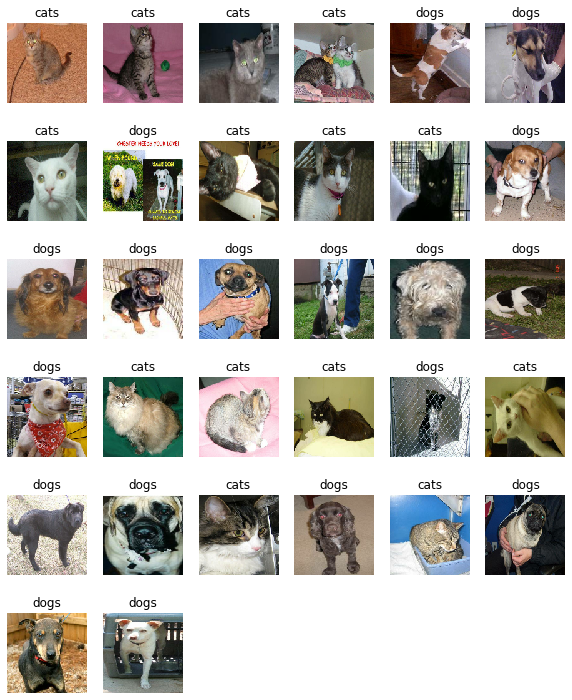

In [10]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(train_dataset))  
show_batch(image_batch, label_batch.numpy())

Train the model for 20 epochs

In [11]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
history = model_3.fit(train_dataset, epochs=20, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

Train for 575.0 steps, validate for 143.75 steps
Epoch 1/20
575/575 [==============================] - 204s 354ms/step - loss: 0.4394 - categorical_accuracy: 0.8013 - val_loss: 0.6623 - val_categorical_accuracy: 0.8492
Epoch 2/20
575/575 [==============================] - 175s 305ms/step - loss: 0.2654 - categorical_accuracy: 0.8857 - val_loss: 0.4223 - val_categorical_accuracy: 0.9028
Epoch 3/20
575/575 [==============================] - 150s 261ms/step - loss: 0.1941 - categorical_accuracy: 0.9185 - val_loss: 0.1344 - val_categorical_accuracy: 0.9386
Epoch 4/20
575/575 [==============================] - 157s 273ms/step - loss: 0.1629 - categorical_accuracy: 0.9284 - val_loss: 0.2954 - val_categorical_accuracy: 0.9329
Epoch 5/20
575/575 [==============================] - 171s 297ms/step - loss: 0.1384 - categorical_accuracy: 0.9461 - val_loss: 3.0955 - val_categorical_accuracy: 0.7704
Epoch 6/20
575/575 [==============================] - 158s 275ms/step - loss: 0.1265 - categorical_ac

Show how the learning progressed

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


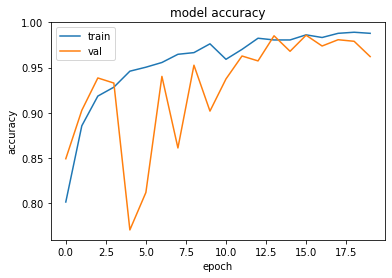

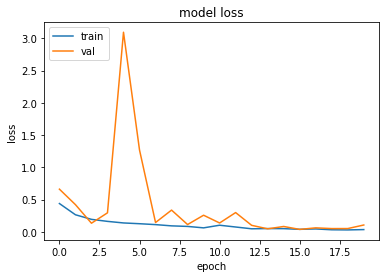

In [12]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Evaluate the model on the testset

In [13]:
model_3.evaluate(testset)

63/63 [==============================] - 6s 90ms/step - loss: 0.2016 - categorical_accuracy: 0.9235


[0.20158629996022062, 0.9235]